## Базовое описание

Предполагается следующий сценарий. Есть название товара, например, "батончик сникерс лесной орех 55г". Необходимо определить к какой группе товаров (состоит из названий многих 100+ названий товаров) оно "ближе".

Например "батончик сникерс лесной орех 55г" ближе к "лесной орех", чем к "стиральный порошок", но при этом еще ближе к "шоколадный батончик сникерс лесной орех", чем просто к "лесной орех". 

## Реализация

Предполагается, что есть БД в которой содержится информация о группах товаров: название группы + название всех товаров группы. Реализация доступа к БД и прочая инфраструктура (сервисы, репозитории и т.п.) на усмотрение исполнителя.

В качестве БД может выступать текстовый файл с JSON. 

Необходимо реализовать сервис, определяющий к какой группе товаров ближе название товара. Сервис содержит один публичный метод (и сколько угодно конструкторов), принимающий название товара и возвращающий название группы и близость к ней.

Предполагается, что реализуемый сервис будет использоваться в нескольких приложениях. 

Unit test на усмотрение исполнителя, минусом точно не будут.

## Бонус уровень (опционально)

Описать в каких случаях разработанный сервис будет работать хорошо, а в каких качество определяемой близости может падать.

In [1]:
import pandas as pd

In [2]:
raw = pd.read_json('../golamago/all_products2.json')

In [3]:
raw.shape

(37805, 4)

В golamago группы иерархичные, поэтому мы избавляемся от top level групп

In [4]:
df = raw[raw['group_id'].str.len() < 7].copy()

Удаляем числа (возможно ли использовать наличие чисел как фичи?) и приводим к нижнему регистру и дропаем дубликаты (одни и те же товары могут находиться в разных категориях)

In [5]:
df['name'] = df['name'].str.lower().replace('[^a-zа-я ]', '', regex=True)
df.drop_duplicates(inplace=True, subset='name')

По условию кол-во товаров в группах может 100+ поэтому дропнем группы где меньше 100 товаров

In [6]:
groups_counts = df['group_id'].value_counts()
df = df[df['group_id'].isin(groups_counts[groups_counts > 100].index)]
df.reset_index(inplace=True, drop=True)

In [7]:
df['group_name'].nunique()

18

In [8]:
df['group_name'].value_counts().plot(kind='bar');

В итоге получили 20 групп, но как видно выборка сильно смещенная

In [9]:
df.shape

(14774, 4)

## Baseline

Попробуем реализовать самое простое решение и возьмем его за бейзлайн

In [10]:
y_train = df['group_name']

Выборка смещенная, поэтому:

> For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used

In [11]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

vect = CountVectorizer(ngram_range=(1, 3))
vect.fit(df['name'])

X_train_counts = vect.transform(df['name'])

clf = MultinomialNB()
clf.fit(X_train_counts, y_train)

y_train_pred = cross_val_predict(clf, X_train_counts, y_train, cv=10)

print(classification_report(y_train, y_train_pred))

                                     precision    recall  f1-score   support

                         Автотовары       0.99      0.82      0.90       265
                            Бакалея       0.84      0.96      0.89      2062
     Бытовая химия, товары для дома       0.89      0.95      0.92      1194
      Готовые блюда и полуфабрикаты       0.89      0.69      0.78       401
                    Детское питание       0.93      0.87      0.90       486
          Консервированные продукты       0.92      0.88      0.90       581
                Косметика и гигиена       0.94      0.96      0.95      1841
            Молочные продукты, яйца       0.93      0.96      0.94      1343
                       Мясо и птица       0.90      0.97      0.94       559
Напитки, соки и безалкогольное пиво       0.94      0.98      0.96       897
        Овощи, фрукты, ягоды, грибы       0.93      0.42      0.57       366
                             Посуда       0.97      0.85      0.91       21

Как бейзлайн сойдет, попробуем поработать лучше с именами

In [14]:
res = pd.DataFrame({
     'name': df['name'],
     'y_train': y_train, 
     'y_train_pred': y_train_pred
})

res[res['y_train_pred'] != res['y_train']];

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier 

# vect = CountVectorizer(ngram_range=(1, 3))
# vect.fit(df['name'])

# X_train_counts = vect.transform(df['name'])

# param_grid = [
#     {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
#     {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
# ]

# clf = RandomForestClassifier()
# grid_search = GridSearchCV(clf, param_grid, cv=5,
#                            scoring='accuracy',
#                            return_train_score=True)

# y_train_pred = cross_val_predict(grid_search, X_train_counts, y_train, cv=10)

# print(classification_report(y_train, y_train_pred))

In [44]:
df.head()

description group_id  \
2479  Молоко ультрапастеризованное с массовой долей ...    7eeyO   
2480  Масло сливочное несоленое, массовая доля жира ...    7eeyO   
2481  Молоко питьевое ультрапастеризованное с массов...    7eeyO   
2482  Молоко питьевое ультрапастеризованное. Массова...    7eeyO   
2484  Молоко имеет низкое содержание лактозы (всего ...    7eeyO   

                   group_name  \
2479  Молочные продукты, яйца   
2480  Молочные продукты, яйца   
2481  Молочные продукты, яйца   
2482  Молочные продукты, яйца   
2484  Молочные продукты, яйца   

                                                 name  is_root_group  
2479       молоко parmalat ультрапастеризованное 3,5%          False  
2480                    масло сливочное экомилк 82,5%          False  
2481                      молоко домик в деревне 3,2%          False  
2482            молоко aro ультрапастеризованное 3,2%          False  
2484  молоко parmalat low lactose низколактозное 1,8%          False

In [45]:
groups_counts = df['group_id'].value_counts()

In [46]:
df = df[df['group_id'].isin(groups_counts[groups_counts > 90].index)]

In [48]:
df.reset_index(inplace=True, drop=True)

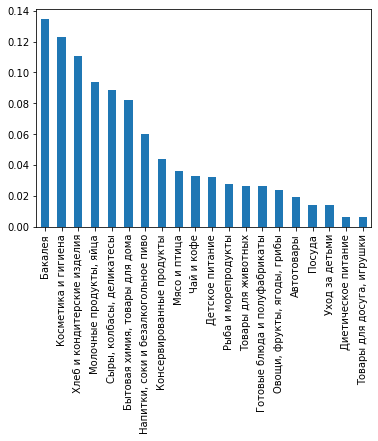

In [52]:
df['group_name'].value_counts(normalize=True).nlargest(20).plot(kind='bar');

In [69]:
df['group_id'].nunique()

24

In [87]:
df['text'] = (df['name'] + ' ' +  df['description']).astype(str)

In [88]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(df['text'].values)

In [89]:
vocab_size = len(tokenizer_obj.word_index) + 1

In [93]:
max_length = max([len(s.split()) for s in df['name']])

In [91]:
X_train_tokens = tokenizer_obj.texts_to_sequences(df['name'])

In [97]:
X_train_pad = pad_sequences(
    X_train_tokens,
    maxlen=max_length,
    padding='post')

In [99]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU

In [101]:
model = Sequential()
model.add(Embedding(10000, 100, input_length=max_length))
model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(df['group_id'].nunique(), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [103]:
model.fit(X_train_pad, df['group_name'], epochs=10, verbose=2)

ValueError: Error when checking target: expected dense_3 to have shape (24,) but got array with shape (1,)